In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
pip install librosa


Feature Extraction:

Loads .wav files using librosa.
Extracts Mel-Frequency Cepstral Coefficients (MFCCs), a popular feature in speech and biomedical signal processing.
Pads or truncates MFCCs to ensure consistent input size.
Data Preparation:

Splits data into training and testing sets.
Reshapes features for LSTM processing.
Model Training:

Uses a Bi-LSTM model for sequential pattern learning.
Applies dropout for regularization.
Uses binary cross-entropy loss for classification.
Resources for Learning
Audio Preprocessing & Feature Extraction

Librosa Documentation
YouTube: Audio Processing in Python
Deep Learning for Heart Sound Classification

Keras LSTM Guide
YouTube: Bi-LSTM for Sequence Learning
PhysioNet Challenge Dataset

Official PhysioNet 2016
This approach combines audio signal processing with NLP-inspired models to detect heart diseases efficiently. Let me know if you need modifications or improvements!

In [5]:
import os
import numpy as np
import librosa
import tensorflow as tf
from glob import glob
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional
from sklearn.model_selection import train_test_split



ModuleNotFoundError: No module named 'tensorflow.keras'

In [3]:
pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.11/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tf_keras


In [4]:
# Provide your train and test dataset paths here
TRAIN_HEALTHY_PATH = "/content/drive/MyDrive/Untitled form (File responses)/KINDLY UPLOAD ANY REFERNCE MATERIAL (File responses)/heart_sound/train/healthy"  # Replace with your train/healthy folder path
TRAIN_UNHEALTHY_PATH = "/content/drive/MyDrive/Untitled form (File responses)/KINDLY UPLOAD ANY REFERNCE MATERIAL (File responses)/heart_sound/train/unhealthy"  # Replace with your train/unhealthy folder path
TEST_HEALTHY_PATH = "/content/drive/MyDrive/Untitled form (File responses)/KINDLY UPLOAD ANY REFERNCE MATERIAL (File responses)/heart_sound/val/healthy"  # Replace with your test/healthy folder path
TEST_UNHEALTHY_PATH = "/content/drive/MyDrive/Untitled form (File responses)/KINDLY UPLOAD ANY REFERNCE MATERIAL (File responses)/heart_sound/val/unhealthy"  # Replace with your test/unhealthy folder path


# Define labels
LABELS = {"healthy": 0, "unhealthy": 1}

In [5]:
# Function to extract MFCC features from a wav file
def extract_features(file_path, max_pad_len=400):
    try:
        audio, sample_rate = librosa.load(file_path, sr=2000)
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]
        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None


In [6]:
# Function to load data from train or test folder
def load_data(healthy_path, unhealthy_path):
    features, labels = [], []

    # Load healthy data
    healthy_files = glob(os.path.join(healthy_path, "*.wav"))
    for file_path in healthy_files:
        feature = extract_features(file_path)
        if feature is not None:
            features.append(feature)
            labels.append(LABELS["healthy"])

    # Load unhealthy data
    unhealthy_files = glob(os.path.join(unhealthy_path, "*.wav"))
    for file_path in unhealthy_files:
        feature = extract_features(file_path)
        if feature is not None:
            features.append(feature)
            labels.append(LABELS["unhealthy"])

    return np.array(features), np.array(labels)

In [7]:
# Load train and test data
X_train, y_train = load_data(TRAIN_HEALTHY_PATH, TRAIN_UNHEALTHY_PATH)
X_test, y_test = load_data(TEST_HEALTHY_PATH, TEST_UNHEALTHY_PATH)


In [9]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train shape: (0,)
y_train shape: (0,)
X_test shape: (0,)
y_test shape: (0,)


In [10]:
# Further split test into validation (50% test, 50% validation)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=42)


ValueError: With n_samples=0, test_size=0.5 and train_size=None, the resulting train set will be empty. Adjust any of the aforementioned parameters.

In [ ]:
# Reshape for LSTM input (samples, time steps, features, channels)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2], 1)


In [ ]:
# Build the Bi-LSTM model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(40, 400))),
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Reshape for LSTM input (samples, time steps, features) - Removing the channels dimension
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2])
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2])
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], X_val.shape[2])

# Build the Bi-LSTM model
model = Sequential([
    Bidirectional(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]))), # Using the correct input shape
    Dropout(0.3),
    Bidirectional(LSTM(32)),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 24s 140ms/step - accuracy: 0.7809 - loss: 0.4849 - val_accuracy: 0.7020 - val_loss: 0.5627
Epoch 2/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 129ms/step - accuracy: 0.8880 - loss: 0.2861 - val_accuracy: 0.7152 - val_loss: 0.5409
Epoch 3/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 19s 117ms/step - accuracy: 0.9206 - loss: 0.2128 - val_accuracy: 0.7947 - val_loss: 0.3982
Epoch 4/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 130ms/step - accuracy: 0.9299 - loss: 0.1792 - val_accuracy: 0.8146 - val_loss: 0.4178
Epoch 5/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 13s 129ms/step - accuracy: 0.9591 - loss: 0.1157 - val_accuracy: 0.8411 - val_loss: 0.2380
Epoch 6/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 123ms/step - accuracy: 0.9654 - loss: 0.0908 - val_accuracy: 0.8543 - val_loss: 0.2328
Epoch 7/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 21s 129ms/step - accuracy: 0.9652 - loss: 0.0828 - val_accuracy: 0.9536 - val_loss: 0.1523
Epoch 8/20
102/102 ━━━━━━━━━━━━━━━━━━━━ 20s 129ms/step - accuracy: 0.9773 - loss: 0

In [ ]:
model.save("SOUND_LSTM_model.h5")


In [ ]:
# Save X_test and y_test
np.save('/content/X_test.npy', X_test)
np.save('/content/y_test.npy', y_test)


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.2f}")

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.9921 - loss: 0.0265
Test Accuracy: 0.99


In [ ]:
#Detection code
import numpy as np
import librosa
import tensorflow as tf

# Load the trained model
MODEL_PATH = "/content/SOUND_LSTM_model.h5"  # Replace with your model file path
model = tf.keras.models.load_model(MODEL_PATH)

# Define labels for prediction
LABELS = {0: "Healthy", 1: "Unhealthy"}

# Function to preprocess a new audio file for prediction
def preprocess_audio(file_path, max_pad_len=400):
    try:
        audio, sample_rate = librosa.load(file_path, sr=2000)  # Load audio file with librosa
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)  # Extract MFCC features

        # Padding or truncating to ensure consistent input length
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]

        # Reshape to match the model input shape (1 sample, time steps, features, channels)
        mfccs = mfccs.reshape(1, mfccs.shape[0], mfccs.shape[1], 1)
        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Function to make prediction
def detect_heart_disease(file_path):
    # Preprocess the audio file
    features = preprocess_audio(file_path)
    if features is None:
        print("Error in preprocessing the audio file.")
        return

    # Make prediction using the model
    prediction = model.predict(features)

    # Convert prediction to class label (0 = Healthy, 1 = Unhealthy)
    predicted_class = 1 if prediction[0] > 0.5 else 0  # Threshold at 0.5 for binary classification
    print(f"Predicted Class: {LABELS[predicted_class]}")

# Example usage
#NEW_AUDIO_FILE = "/content/drive/MyDrive/Untitled form (File responses)/KINDLY UPLOAD ANY REFERNCE MATERIAL (File responses)/heart_sound/train/healthy/a0007.wav"  # Replace with the path to your new .wav file
NEW_AUDIO_FILE="/content/drive/MyDrive/Untitled form (File responses)/KINDLY UPLOAD ANY REFERNCE MATERIAL (File responses)/heart_sound/train/unhealthy/a0005.wav"
detect_heart_disease(NEW_AUDIO_FILE)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 594ms/step
Predicted Class: Unhealthy


In [ ]:
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Load the trained model
MODEL_PATH = "/content/SOUND_LSTM_model.h5"  # Replace with your model file path
model = tf.keras.models.load_model(MODEL_PATH)

# Define labels for prediction
LABELS = {0: "Healthy", 1: "Unhealthy"}

# Function to preprocess a new audio file for prediction
def preprocess_audio(file_path, max_pad_len=400):
    try:
        audio, sample_rate = librosa.load(file_path, sr=2000)  # Load audio file with librosa
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)  # Extract MFCC features

        # Padding or truncating to ensure consistent input length
        pad_width = max_pad_len - mfccs.shape[1]
        if pad_width > 0:
            mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        else:
            mfccs = mfccs[:, :max_pad_len]

        # Reshape to match the model input shape (1 sample, time steps, features, channels)
        mfccs = mfccs.reshape(1, mfccs.shape[0], mfccs.shape[1], 1)
        return mfccs
    except Exception as e:
        print(f"Error processing {file_path}: {e}")
        return None

# Function to make prediction
def detect_heart_disease(file_path):
    # Preprocess the audio file
    features = preprocess_audio(file_path)
    if features is None:
        print("Error in preprocessing the audio file.")
        return

    # Make prediction using the model
    prediction = model.predict(features)

    # Convert prediction to class label (0 = Healthy, 1 = Unhealthy)
    predicted_class = 1 if prediction[0] > 0.5 else 0  # Threshold at 0.5 for binary classification
    print(f"Predicted Class: {LABELS[predicted_class]}")
    return predicted_class

# Evaluate the model on test set and generate confusion matrix
def evaluate_model(X_test, y_test):
    # Predict on the test data
    y_pred = model.predict(X_test)
    y_pred_class = (y_pred > 0.5).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_class)
    print("Confusion Matrix:")
    print(cm)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_class, target_names=["Healthy", "Unhealthy"]))

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Unhealthy"], yticklabels=["Healthy", "Unhealthy"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return y_pred_class

# Plot model accuracy and loss curves
def plot_metrics(history):
    # Accuracy Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
NEW_AUDIO_FILE = "/content/drive/MyDrive/Untitled form (File responses)/KINDLY UPLOAD ANY REFERNCE MATERIAL (File responses)/heart_sound/train/unhealthy/a0005.wav"  # Replace with the path to your new .wav file
predicted_class = detect_heart_disease(NEW_AUDIO_FILE)

# Load model history for plotting (ensure that model training includes the history)
# Uncomment this after training the model and saving the history
# plot_metrics(history)

# Evaluate model (use your actual test data `X_test`, `y_test` here)
# Assuming you have X_test and y_test from your dataset:
# y_pred_class = evaluate_model(X_test, y_test)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted Class: Unhealthy


In [ ]:
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ bidirectional_4 (Bidirectional)      │ (None, 40, 128)             │         238,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 40, 128)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_5 (Bidirectional)      │ (None, 64)                  │          41,216 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 281,411 (1.07 MB)

 Trainable params: 281,409 (1.07 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

Confusion Matrix:
[[75  0]
 [ 1 74]]

Classification Report:
              precision    recall  f1-score   support

     Healthy       0.99      1.00      0.99        75
   Unhealthy       1.00      0.99      0.99        75

    accuracy                           0.99       150
   macro avg       0.99      0.99      0.99       150
weighted avg       0.99      0.99      0.99       150



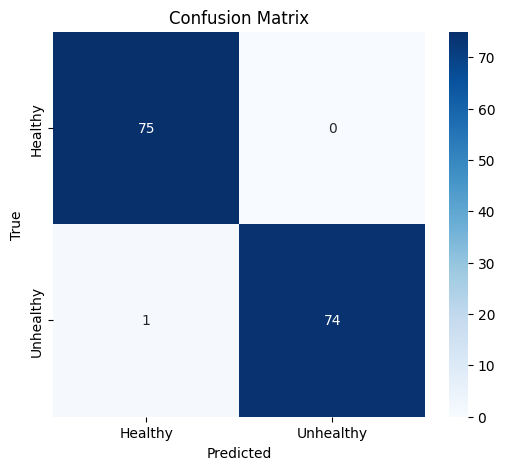

array([[0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [0],
       [1],
       [1],
       [1],
       [1],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [1],
       [1],
       [0],
       [0],
       [0],
       [0],
       [1],
       [0],
       [0],
       [1],
       [1],
       [0],
       [1],
       [0],
       [0],
    

In [ ]:
import numpy as np
import librosa
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Load the trained model
MODEL_PATH = "/content/SOUND_LSTM_model.h5"  # Replace with your model file path
model = tf.keras.models.load_model(MODEL_PATH)

# Define labels for prediction
LABELS = {0: "Healthy", 1: "Unhealthy"}

# Evaluate the model on test set and generate confusion matrix
def evaluate_model(X_test, y_test):
    # Predict on the test data
    y_pred = model.predict(X_test, verbose=0)  # verbose=0 to suppress retracing warnings
    y_pred_class = (y_pred > 0.5).astype(int)

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred_class)
    print("Confusion Matrix:")
    print(cm)

    # Classification Report
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred_class, target_names=["Healthy", "Unhealthy"]))

    # Plot Confusion Matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Healthy", "Unhealthy"], yticklabels=["Healthy", "Unhealthy"])
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

    return y_pred_class

# Assuming you have X_test and y_test from your dataset:
# You need to have these arrays from your original dataset

# Example:
# X_test, y_test = ...  # Load or prepare your test data here

# Evaluate the model
evaluate_model(X_test, y_test)
